## NYC Sales Model

**Aim:** To estimate the sales price with different information such as the age of the building, size and location.

   - For this purpose, I will clear the data.
   - Then I will make the data ready for the model with preprocessing steps. 
   - In order to understand whether this data can solve this problem, I will set up a base model with MVP quality.
   - And the results will guide the next development steps.
   
If the comments are not enough, the reason may have been explained in the previous EDA notebook, check it out.  Or feel free to contact me to reveal blind spots. Or feel free to contact me (*sengulkaraderili@gmail.com*) to reveal blind spots.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import shap
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Users/skaraderili/miniconda3/envs/nyc_sales/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read data with nan values reperesented as ' -  ', dont convert again.
file_path = "nyc-rolling-sales.csv"
df = pd.read_csv(file_path, na_values=' -  ')

### Feature engineering and cleaning


#### Convert data types

In [3]:
# Specifying date variable and correcting its type
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce') 
# df["dayofweek"] = df['SALE DATE'].dt.dayofweek
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype(object)

In [4]:
# Specifying numeric variables and correcting their types
numeric = ["RESIDENTIAL UNITS","COMMERCIAL UNITS","TOTAL UNITS", "LAND SQUARE FEET" ,
           "GROSS SQUARE FEET","SALE PRICE" ]
for col in numeric: 
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [5]:
# Specifying categorical variables and correcting their types
categorical = ["BOROUGH","NEIGHBORHOOD",'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
               'BUILDING CLASS AT PRESENT','ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'TAX CLASS AT TIME OF SALE']
for col in categorical: 
    df[col] = df[col].astype(object)

#### Impute missing values

We will fill in our missing data with the median values of the borough categories. Thus, the differences between the categories will not be ignored.

In [6]:
df.replace(' ',np.nan, inplace=True)

In [7]:
# Imputing missing values of theese columns.
df['GROSS SQUARE FEET']=df.groupby('BOROUGH')['GROSS SQUARE FEET'].apply(lambda x:x.fillna(x.median()))
df['LAND SQUARE FEET']=df.groupby('BOROUGH')['LAND SQUARE FEET'].apply(lambda x:x.fillna(x.median()))

In [8]:
df = df[df["SALE PRICE"] > 0]  # Deleting 0 price transfer transactions 
df = df[df["SALE PRICE"].notnull()] # Deleting nan values of dependence variable

#### Cleaning: Drop and filter columns


In [9]:
del df["ADDRESS"] # The variable 1 not required for the model
del df["ZIP CODE"] # The variable 2 not required for the model
del df["SALE DATE"] # We don't need it as we have created the year and month variables.
df.drop(["EASE-MENT","APARTMENT NUMBER"], axis=1, inplace=True) # Completely empty columns.

df = df.dropna() 
df.drop_duplicates(keep = "last", inplace=True)

In [10]:
# Year cannot be 0.
df = df[df['YEAR BUILT'] != 0]
del df['YEAR BUILT']

In [11]:
# Square feet should not be 0.
df = df[df["LAND SQUARE FEET"] != 0]
df = df[df["GROSS SQUARE FEET"] != 0]

In [12]:
del df["LOT"]

In [13]:
del df["Unnamed: 0"]

In [14]:
# Deleting of unnecessary categorical variables for the model

del df["NEIGHBORHOOD"]
del df['BUILDING CLASS AT TIME OF SALE']
del df['TAX CLASS AT PRESENT']

In [15]:
# Drop the highly correlated ones to avoid multi collienearity
del df['RESIDENTIAL UNITS']
del df['TOTAL UNITS']
del df["BUILDING CLASS AT PRESENT"]

#### Handling categorical variables

In [16]:
# Get dummies of cat variables.
borough_dummies = pd.get_dummies(df['BOROUGH']).rename(columns=lambda x: 'BOROUGH_' + str(x))
tax_class_dummies = pd.get_dummies(df['TAX CLASS AT TIME OF SALE']).rename(columns=lambda x: 'TAX CLASS AT TIME OF SALE_' + str(x))
build_class = pd.get_dummies(df['BUILDING CLASS CATEGORY']).rename(columns=lambda x: 'BUILDING CLASS CATEGORY_' + str(x))

# Concat them.
df = pd.concat([df, borough_dummies,tax_class_dummies, build_class], axis=1)

# Delete categorical columns after encoding.
df = df.drop(['BOROUGH','TAX CLASS AT TIME OF SALE','BUILDING CLASS CATEGORY'],axis=1)

#### Train test split

In [17]:
X = df.drop(["SALE PRICE"],axis = 1).astype(int)
y = df["SALE PRICE"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle= True)

#### Apply standart scaler

In [18]:
from sklearn.preprocessing import MinMaxScaler

numeric_cols =  ['COMMERCIAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET']

        
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]= scaler.transform(X_test[numeric_cols])

In [19]:
X_train.head()

,BLOCK,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX CLASS AT TIME OF SALE_1,...,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE
58373,5066,0.0,0.000618,0.000422,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
77805,5645,0.0,0.000300,0.000340,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
311,771,0.0,0.000552,0.002230,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58521,5066,0.0,0.000618,0.000422,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64947,9951,0.0,0.001152,0.000344,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Modelling

I think a tree-based regressor would work, as we have plenty of categorical variables.

I will try;

    - Random Forest as a base model
    - Gradient Boosting
    - XGB

#### Base Model

In [21]:
gb = GradientBoostingRegressor(random_state = 42)
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)

print("Train score of Gradient Boosting model: ",gb.score(X_train,y_train))
print("Test score of Gradient Boosting model: ",gb.score(X_test,y_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))

Train score of Gradient Boosting model:  0.9417675133309573
Test score of Gradient Boosting model:  0.35127297775101063
RMSE: 8129209.8015668895


In [22]:
xg = xg.XGBRegressor(random_state = 42)
xg.fit(X_train,y_train)
y_pred = xg.predict(X_test)

print("Train score of XGB model: ",xg.score(X_train,y_train))
print("Test score of XGB model: ",xg.score(X_test,y_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))

Train score of XGB model:  0.9798402463371613
Test score of XGB model:  0.242677301695589
RMSE: 8783302.184452822


In [28]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("Train score of base model: ",rf.score(X_train,y_train))
print("Test score of base model: ",rf.score(X_test,y_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))

Train score of base model:  0.8540610659528791
Test score of base model:  0.47562572092820143
RMSE: 7308664.535379451


RMSE tells us explicitly how much our predictions deviate, on average, from the actual values in the dataset. In this case, the predicted values are $7,591,329 away from the actual value.

Looks like we ran into it with overfitting. While r2 is 0.85 in the train set, it is 0.47 in the test set.


As can be seen, as the model complexity increases, the overfitting also increases. Therefore, I will continue with the random forest.


There are some suggestions that can be made in the random forest to overcome this:
- max_features: try reducing this number (try 30-50% of the number of features)
- max_depth: This will reduce the complexity of the learned models, lowering over fitting risk

ref: https://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting & https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

I'll use grid search to try these out.

#### Optimized Random Forest

In [23]:
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[5, 10, 15],
    "max_features":[6,16,30,45],
    "ccp_alpha": [0,1]  # Minimal Cost-Complexity Pruning to avoid overfitting
}

rf = RandomForestRegressor(random_state = 42)

rf_tuned = GridSearchCV(estimator = rf,
                            param_grid = param_grid,
                            cv = 5,
                            n_jobs=-1,
                        verbose=0)

rf_tuned.fit(X_train, y_train)
rf_tuned.best_estimator_

RandomForestRegressor(ccp_alpha=0, max_depth=15, max_features=6,
                      n_estimators=300, random_state=42)

In [24]:
best_model = rf_tuned.best_estimator_.fit(X_train,y_train) # Grid Search result

In [25]:
print("Train score of optimized model: ",best_model.score(X_train,y_train))
print("Test score of optimized model: ",best_model.score(X_test,y_test))

Train score of optimized model:  0.8934056181778522
Test score of optimized model:  0.5316075292325788


### Error Analysis

Optimizing improved the estimates by 1 percent, but there is still overfitting. To understand this, it is necessary to examine in more detail the features we give to the model.

First, I will use the game theory-based model explicability library SHAP. It will help us understand the contribution of these features to the model and why the model decides on that output.
Doc: https://shap.readthedocs.io/en/latest/index.html

Since the runtime is long, I will look at the importance with RF feature_importances_.

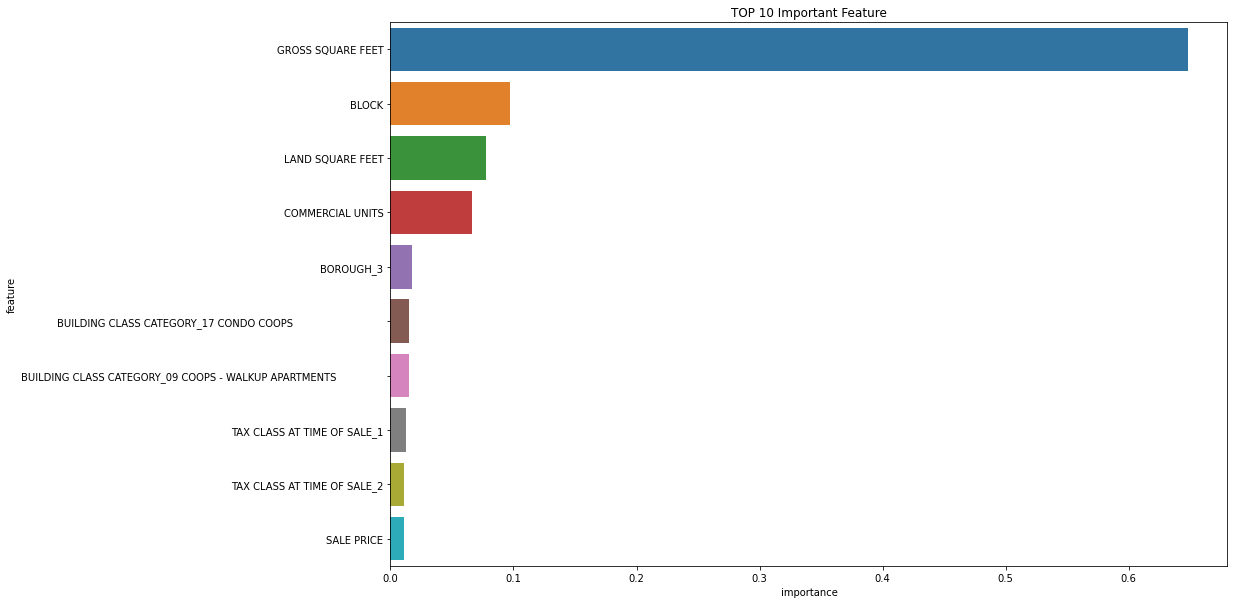

In [29]:
feat_imp = rf.feature_importances_.tolist()
imp_df = pd.DataFrame(sorted(zip(df.columns,feat_imp),reverse=True),
                          columns=["feature","importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(15,10))
sns.barplot(x="importance",
            y="feature",
            data=imp_df[:10]).set_title("TOP 10 Important Feature")
plt.show()

### Conclusion:

- Since we don't have linear and time series data and we need a categorical regressor, I used tree-based methods.

- Random Forest Regressor with the best results. However, there is still an overfitting problem. To avoid this, we can use one of the methods of punishment or feature selection.

- The GROSS SQUARE FEET, BLOCK, LAND SQUARE FEET variables were the variables that affected the model the most.

- Columns with numerical information (Inflation, exchange rates, etc.) that can be correlated with sale price can be found and added to the model, and a model with lower complexity can be established. 
